## PIMS Hackathon, Seattle 2025
### Project B - Preconditioners for Thermal Radiative Transfer
Packages: jupyter, numpy, matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from solvers import *
from post_process import *

L2  : 8.762331740438677e-10
Linf: 4.312269652473333e-09


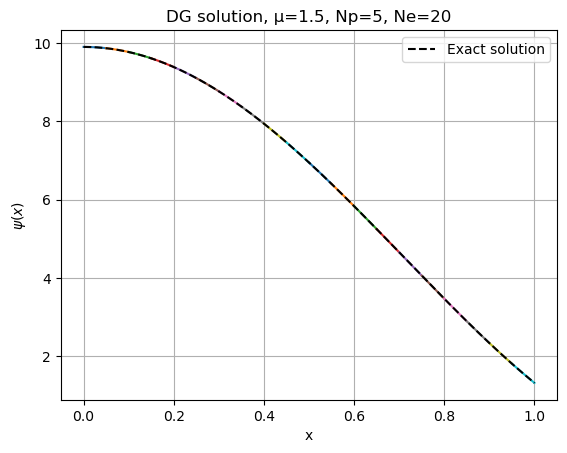

In [2]:
# ─── Example usage ───

# Parameters for the transport problem
μ       = 1.5
σ_t     = lambda x: x**2 + 1
source  = lambda x: (μ**3)*(2*x - 6.8*np.sin(2*x)) + (σ_t(x) * (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)))
inflow  = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x))

# Mesh parameters
Ne = 20
xs      = np.linspace(0, 1, Ne + 1) # Mesh points / element boundaries
Np      = 5                     # Legendre polynomials per element (basis size)

# Plot numerical solution against the exact solution (MMS)
ψ_MMS     = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x))
ψ_weights = transport_direct_solve(μ, σ_t, compute_source_term(source, Np, xs), inflow, Np, xs)
ψ_weights = ψ_weights.reshape(Ne, Np)

# Print the error in the solution
print("L2  :",error_Lp(ψ_weights, xs, Np, ψ_MMS, p=2))
print("Linf:",error_Lp(ψ_weights, xs, Np, ψ_MMS, p='inf'))
plot_solution(ψ_weights, xs, Np, μ=μ, exact_ψ_func=ψ_MMS)

 12%|█▎        | 25/200 [00:04<00:28,  6.15it/s]


Converged in 25 iterations
Chosen μ: -0.6546536707079773
L2  : 1.657725563016653e-12
Linf: 4.560130051345368e-12


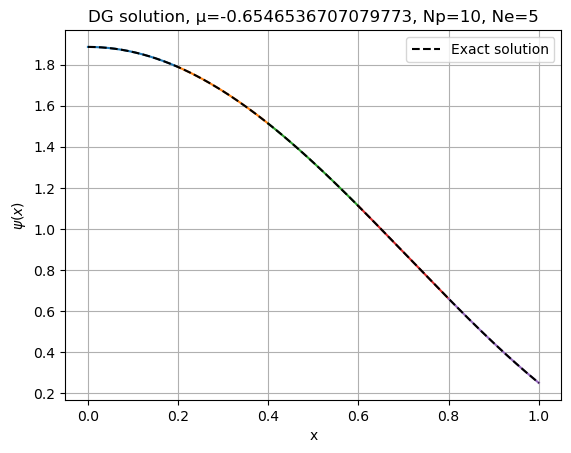

In [3]:
# ─── Example usage (Fixed point iteration) ───

# Parameters for the transport problem
ψ_MMS  = lambda x,μ: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactured solution
σ_t    = lambda x: x**3 + 1
σ_a    = lambda x: x**2 + 1
ε      = 0.5
source = lambda x,μ: (μ**3)/ε * (2*x - 6.8*np.sin(2*x)) + (σ_t(x)/ε**2 * ψ_MMS(x,μ)) \
                   - (σ_t(x)/ε - ε*σ_a(x)) / (3*ε) * ((x**2 +1) + 3.4*np.cos(2*x))
inflow = lambda x,μ: ψ_MMS(x,μ)
 
# Mesh parameters
Np = 10                      # Legendre polynomials per element (basis size)
Nμ = 5                      # Legendre polynomials per element (basis size)
xs = np.linspace(0, 1, 6) # Mesh points / element boundaries

# Solve
ψ_weights_all, μs, t = transport_direct_solve_diffusive(σ_t, σ_a, ε, source, inflow, Np, Nμ, xs, 
                                                     max_iter=int(200), tol=1e-10, preconditioning=True)
μi = 1 # Chosen μ for the error calculation
μc = μs[μi]
print("Chosen μ:", μc)

# Print the error in the solution
print("L2  :",error_Lp(ψ_weights_all[μi,:,:], xs, Np, lambda x: ψ_MMS(x,μc), p=2))
print("Linf:",error_Lp(ψ_weights_all[μi,:,:], xs, Np, lambda x: ψ_MMS(x,μc), p='inf'))

# Plot numerical solution against the exact solution (MMS)
plot_solution(ψ_weights_all[μi,:,:], xs, Np, μ=μc, exact_ψ_func=lambda x: ψ_MMS(x,μc))

  0%|          | 10/100000 [00:00<29:52, 55.79it/s]


Converged in 10 iterations


  0%|          | 49/100000 [00:00<24:49, 67.10it/s]


Converged in 49 iterations


  0%|          | 161/100000 [00:02<23:43, 70.15it/s]


Converged in 161 iterations


  1%|          | 526/100000 [00:07<23:32, 70.43it/s]


Converged in 526 iterations


  2%|▏         | 1808/100000 [00:25<22:37, 72.32it/s]


Converged in 1808 iterations


  6%|▋         | 6439/100000 [01:28<21:28, 72.62it/s]


Converged in 6439 iterations


 23%|██▎       | 23336/100000 [03:35<11:48, 108.18it/s]


Converged in 23336 iterations


 85%|████████▌ | 85057/100000 [11:09<01:57, 126.99it/s]


Converged in 85057 iterations


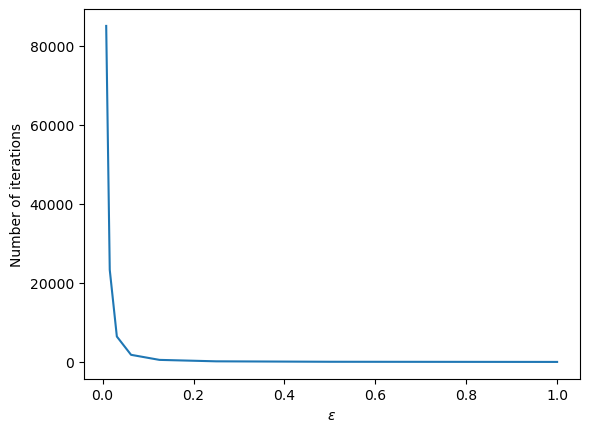

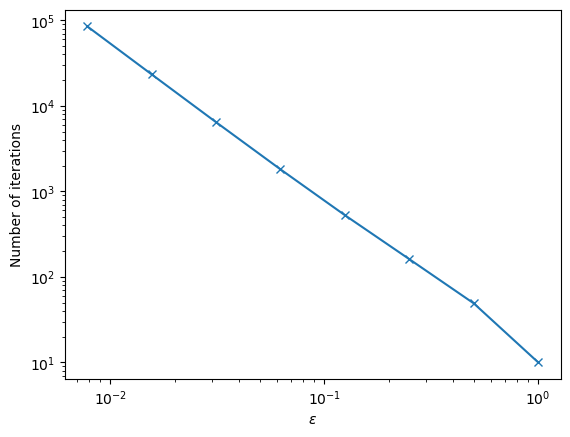

In [4]:
εs = [1*0.5**i for i in range(8)]
n_iter = []
for ε in εs:
    # Parameters for the transport problem
    ψ_MMS  = lambda x,μ: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactured solution
    σ_t    = lambda x: x**3 + 1
    σ_a    = lambda x: x**2 + 1
    source = lambda x,μ: (μ**3)/ε * (2*x - 6.8*np.sin(2*x)) + (σ_t(x)/ε**2 * ψ_MMS(x,μ)) \
                    - (σ_t(x)/ε - ε*σ_a(x)) / (3*ε) * ((x**2 +1) + 3.4*np.cos(2*x))
    inflow = lambda x,μ: ψ_MMS(x,μ)
    
    # Mesh parameters
    Np = 3                      # Legendre polynomials per element (basis size)
    Nμ = 5                      # Legendre polynomials per element (basis size)
    xs = np.linspace(0, 1, 6) # Mesh points / element boundaries

    # Solve
    ψ_weights_all, μs, t = transport_direct_solve_diffusive(σ_t, σ_a, ε, source, inflow, Np, Nμ, xs, 
                                                        max_iter=int(1e5), tol=1e-10)
    n_iter.append(t)

plt.plot(εs, n_iter)
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"Number of iterations")
plt.savefig("test_figures/n_iter_vs_epsilon.pdf")
plt.show()

plt.plot(εs, n_iter, 'x-')
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"Number of iterations")
plt.xscale("log")
plt.yscale("log")
plt.savefig("test_figures/n_iter_vs_epsilon_log_log.pdf")
plt.show()

  0%|          | 8/100000 [00:00<33:18, 50.04it/s]


Converged in 8 iterations


  0%|          | 23/100000 [00:00<16:53, 98.61it/s] 


Converged in 23 iterations


  0%|          | 30/100000 [00:00<16:11, 102.87it/s]


Converged in 30 iterations


  0%|          | 31/100000 [00:00<15:46, 105.66it/s]


Converged in 31 iterations


  0%|          | 30/100000 [00:00<19:39, 84.74it/s]


Converged in 30 iterations


  0%|          | 30/100000 [00:00<16:36, 100.35it/s]


Converged in 30 iterations


  0%|          | 31/100000 [00:00<15:17, 109.01it/s]


Converged in 31 iterations


  0%|          | 33/100000 [00:00<15:39, 106.41it/s]

Converged in 33 iterations


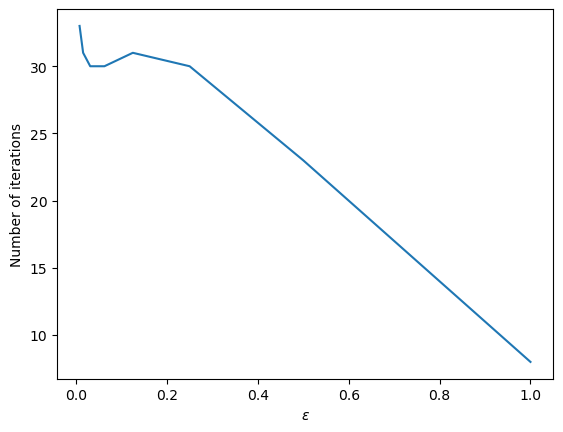

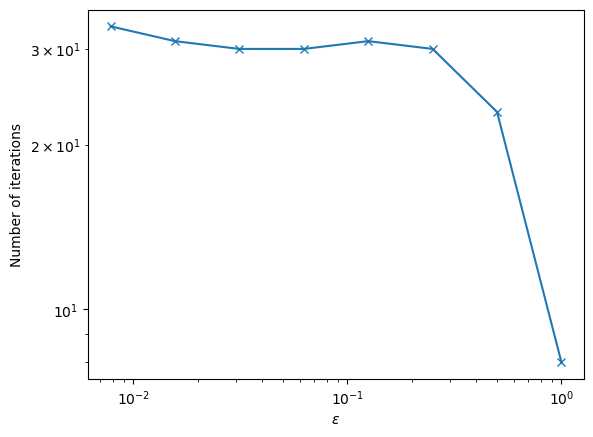

In [5]:
εs = [1*0.5**i for i in range(8)]
n_iter = []
for ε in εs:
    # Parameters for the transport problem
    ψ_MMS  = lambda x,μ: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactured solution
    σ_t    = lambda x: x**3 + 1
    σ_a    = lambda x: x**2 + 1
    source = lambda x,μ: (μ**3)/ε * (2*x - 6.8*np.sin(2*x)) + (σ_t(x)/ε**2 * ψ_MMS(x,μ)) \
                    - (σ_t(x)/ε - ε*σ_a(x)) / (3*ε) * ((x**2 +1) + 3.4*np.cos(2*x))
    inflow = lambda x,μ: ψ_MMS(x,μ)
    
    # Mesh parameters
    Np = 3                      # Legendre polynomials per element (basis size)
    Nμ = 5                      # Legendre polynomials per element (basis size)
    xs = np.linspace(0, 1, 6) # Mesh points / element boundaries

    # Solve
    ψ_weights_all, μs, t = transport_direct_solve_diffusive(σ_t, σ_a, ε, source, inflow, Np, Nμ, xs, 
                                                        max_iter=int(1e5), tol=1e-10, preconditioning=True)
    n_iter.append(t)

plt.plot(εs, n_iter)
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"Number of iterations")
plt.savefig("test_figures/n_iter_vs_epsilon_w_preconditioning.pdf")
plt.show()

plt.plot(εs, n_iter, 'x-')
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"Number of iterations")
plt.xscale("log")
plt.yscale("log")
plt.savefig("test_figures/n_iter_vs_epsilon_w_preconditioning_log_log.pdf")
plt.show()

/Users/rsz/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/daily_folders/Python/Test/PIMS_hack/PIMS-GroupB/library.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  w[i] = 2.0 / (N * (N-1) * (Pn_1_val**2))
  0%|          | 15/100000 [00:00<10:54, 152.86it/s]


Converged in 15 iterations
Np = 1, Ne = 2, L2 = 0.3039226557844569


  0%|          | 15/100000 [00:00<12:10, 136.89it/s]


Converged in 15 iterations
Np = 1, Ne = 4, L2 = 0.1641178952445338


  0%|          | 15/100000 [00:00<16:20, 102.00it/s]


Converged in 15 iterations
Np = 1, Ne = 8, L2 = 0.08540562749054938


  0%|          | 15/100000 [00:00<24:05, 69.15it/s]

Converged in 15 iterations


Np = 1, Ne = 16, L2 = 0.0435938408708209


  0%|          | 16/100000 [00:00<39:01, 42.70it/s]


Converged in 16 iterations
Np = 1, Ne = 32, L2 = 0.0220289143556209


  0%|          | 15/100000 [00:00<19:44, 84.39it/s]

Converged in 15 iterations
Np = 2, Ne = 2, L2 = 0.04261553320249008



  0%|          | 15/100000 [00:00<24:21, 68.41it/s]

Converged in 15 iterations


Np = 2, Ne = 4, L2 = 0.011431150057764712


  0%|          | 15/100000 [00:00<35:37, 46.77it/s]


Converged in 15 iterations
Np = 2, Ne = 8, L2 = 0.002936506718514844


  0%|          | 16/100000 [00:00<1:18:08, 21.32it/s]


Converged in 16 iterations
Np = 2, Ne = 16, L2 = 0.0007427454117719692


  0%|          | 16/100000 [00:01<2:01:43, 13.69it/s]


Converged in 16 iterations
Np = 2, Ne = 32, L2 = 0.00018667683305081972


  0%|          | 15/100000 [00:00<29:11, 57.10it/s]


Converged in 15 iterations
Np = 3, Ne = 2, L2 = 0.0050792737682427555


  0%|          | 15/100000 [00:00<41:15, 40.38it/s]


Converged in 15 iterations
Np = 3, Ne = 4, L2 = 0.0006585510938149964


  0%|          | 15/100000 [00:00<1:13:24, 22.70it/s]


Converged in 15 iterations
Np = 3, Ne = 8, L2 = 8.394483992737927e-05


  0%|          | 16/100000 [00:01<2:23:31, 11.61it/s]


Converged in 16 iterations
Np = 3, Ne = 16, L2 = 1.0599119821581701e-05


  0%|          | 16/100000 [00:02<4:20:19,  6.40it/s]


Converged in 16 iterations
Np = 3, Ne = 32, L2 = 1.331661724659738e-06


  0%|          | 15/100000 [00:00<44:24, 37.53it/s]


Converged in 15 iterations
Np = 4, Ne = 2, L2 = 0.000265039068727837


  0%|          | 15/100000 [00:00<1:09:14, 24.07it/s]


Converged in 15 iterations
Np = 4, Ne = 4, L2 = 1.7097745345822048e-05


  0%|          | 16/100000 [00:01<2:10:36, 12.76it/s]


Converged in 16 iterations
Np = 4, Ne = 8, L2 = 1.0797114802165376e-06


  0%|          | 16/100000 [00:02<3:51:25,  7.20it/s]


Converged in 16 iterations
Np = 4, Ne = 16, L2 = 6.77437964334664e-08


  0%|          | 16/100000 [00:04<7:56:25,  3.50it/s]


Converged in 16 iterations
Np = 4, Ne = 32, L2 = 4.24078485680766e-09


  0%|          | 15/100000 [00:00<1:02:47, 26.54it/s]


Converged in 15 iterations
Np = 5, Ne = 2, L2 = 1.6077772137795e-05


  0%|          | 15/100000 [00:01<1:55:16, 14.46it/s]


Converged in 15 iterations
Np = 5, Ne = 4, L2 = 5.111852538448865e-07


  0%|          | 16/100000 [00:01<3:13:35,  8.61it/s]


Converged in 16 iterations
Np = 5, Ne = 8, L2 = 1.6135000914083283e-08


  0%|          | 17/100000 [00:03<5:57:05,  4.67it/s]

Converged in 17 iterations
Np = 5, Ne = 16, L2 = 5.068833392044563e-10



  0%|          | 16/100000 [00:07<12:18:26,  2.26it/s]

Converged in 16 iterations
Np = 5, Ne = 32, L2 = 1.5882186943001104e-11


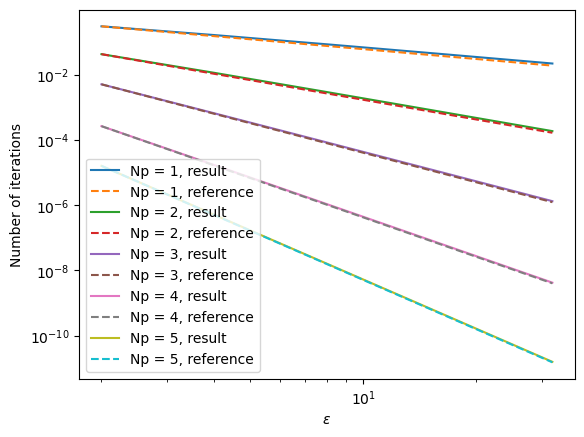

In [48]:
n_iter = []
Nps = [1, 2, 3, 4, 5]
Nes = [2, 4, 8, 16, 32]
results = {}

for Np in Nps:
    results[Np] = []
    for Ne in Nes:
        ε = 0.9
        # Parameters for the transport problem
        ψ_MMS  = lambda x,μ: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactured solution
        σ_t    = lambda x: x**3 + 1
        σ_a    = lambda x: x**2 + 1
        source = lambda x,μ: (μ**3)/ε * (2*x - 6.8*np.sin(2*x)) + (σ_t(x)/ε**2 * ψ_MMS(x,μ)) \
                        - (σ_t(x)/ε - ε*σ_a(x)) / (3*ε) * ((x**2 +1) + 3.4*np.cos(2*x))
        inflow = lambda x,μ: ψ_MMS(x,μ)
        
        # Mesh parameters
        Nμ = 5                      # Legendre polynomials per element (basis size)
        xs = np.linspace(0, 1, Ne+1) # Mesh points / element boundaries

        # Solve
        ψ_weights_all, μs, t = transport_direct_solve_diffusive(σ_t, σ_a, ε, source, inflow, Np, Nμ, xs, 
                                                            max_iter=int(1e5), tol=1e-14)
        L2 = error_Lp(ψ_weights_all[μi,:,:], xs, Np, lambda x: ψ_MMS(x,μc), p=2)
        results[Np].append(L2)
        print(f"Np = {Np}, Ne = {Ne}, L2 = {L2}")
    plt.plot(Nes, results[Np], label=f"Np = {Np}, result")
    # dashed line
    plt.plot(Nes, [results[Np][0] * (Ne/2)**(-Np) for Ne in Nes], '--', label=f"Np = {Np}, reference")
plt.legend()
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"Number of iterations")
plt.xscale("log")
plt.yscale("log")
plt.savefig("test_figures/error_vs_Np_and_Ne.pdf")
    # plt.show()
